<a href="https://colab.research.google.com/github/ovieimara/ITNPAI1/blob/master/TS_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install ydata_profiling

In [ ]:
from os import sendfile
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any
from statsmodels.tsa.seasonal import seasonal_decompose
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ydata_profiling import ProfileReport
import seaborn as sns

In [ ]:

class TimeSeriesABC(ABC):
  @abstractmethod
  def generate_time_series(self, *args, **kwargs) -> np.ndarray:
      pass


  @abstractmethod
  def generate_date_range(self, *args, **kwargs) -> pd.DatetimeIndex:
      pass

  @abstractmethod
  def generate_smooth_seasonality(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def save_to_csv(self, *args, **kwargs) -> None:
      pass


  @abstractmethod
  def decompose_time_series(self, df, x_col, y_col, frequency='D'):
      pass

@dataclass()
class TimeSeriesGenerator(TimeSeriesABC):
  n_periods: int =100
  frequency: str = 'days'
  trend_slope: float = 0.3
  seasonal_period: str = 'monthly'
  seasonal_amplitude: float = 5
  noise_level: float = 0.5
  base_demand: int = 50  # Average daily demand


  def __post_init__ (self):
    #set seasonal_frequency

    self.seasonality()

    #Create a linear trend: A simple increasing trend from 0 to trend_slope * n_periods
    np.random.seed(42)

    self.trend = np.linspace(0, self.trend_slope * self.n_periods, self.n_periods)  # Linear trend

    #Add minimal noise to the time series to make the residuals more realistic
    self.noise = np.random.normal(0, self.noise_level, self.n_periods)


  def generate_date_range(self, start_date: str ='2018-01-01') -> pd.DatetimeIndex :
    # Set frequency based on the input (days, months, or weeks)
    if self.frequency == 'days':
        freq = 'D'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    elif self.frequency == 'months':
        freq = 'M'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    elif self.frequency == 'weeks':
        freq = 'W'
        self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)
    else:
        raise ValueError("Frequency should be 'days', 'months', or 'weeks'.")

    return self.time_index

  def seasonality(self) -> None:

    if self.seasonal_period == 'monthly':
        # One full cycle per year (12 months)
        self.seasonal_frequency = 2 * np.pi / 12  # For monthly frequency
    elif self.seasonal_period == 'weekly':
        # One full cycle per year (52 weeks)
        self.seasonal_frequency = 2 * np.pi / 52  # For weekly frequency
    elif self.seasonal_period == 'annual':
        # One full cycle per year (365 days)
        self.seasonal_frequency = 2 * np.pi / 365  # For annual frequency
    else:
        raise ValueError("Seasonal period should be 'monthly', 'weekly', or 'annual'.")

  def generate_smooth_seasonality(self) -> None:
    # Smooth seasonal component (sine wave with the defined frequency)
    np.random.seed(42)
    self.seasonal_component = self.seasonal_amplitude * np.sin(np.linspace(0, self.seasonal_frequency * self.n_periods, self.n_periods))

  def generate_time_series(self) -> np.ndarray:
    #Combine the trend, seasonality and noise to form a time series

    return  self.base_demand + self.trend + self.seasonal_component + self.noise

  def create_dataframe(self, x_col: str, y_col: str) -> pd.DataFrame:
    time_series = self.generate_time_series()
    # Prepare dataframe
    data = {x_col: self.time_index[:len(time_series)], y_col: np.ceil(time_series)}
    return pd.DataFrame(data)

  # def column_int(self, df: pd.DataFrame, col_name: str) -> pd.DataFrame:
  #   df[col_name] = df[col_name].apply(lambda x: round(x))
  #   return df

  def plot_time_series(self, df: pd.DataFrame, x_col: str, y_col: str):
    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], label='Simulated Time Series For V.Ger Travel Car Rental Services')
    plt.title('Simulated Time Series Data with Trend and Seasonality')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.legend()
    plt.show()

  def save_to_csv(self, df, file_path) -> None:
    # Save the DataFrame to a CSV file
    df.to_csv(file_path, index=False)
    print("Time series data saved to 'generated_time_series.csv'.")


  def decompose_time_series(self, df,  x_col, y_col: str, frequency='D') -> Any:
    # Ensure the 'Time' column is in datetime format
    # df[x_col] = pd.to_datetime(df[x_col])

    # Set 'Time' as the index
    # df.set_index(x_col, inplace=True)

    # Perform decomposition
    decomposition = seasonal_decompose(df[y_col], model='additive', period=365 if self.frequency == 'days' else 12)
    return decomposition


  def plot_decomposition(self, decomposition):
    # Plot the decomposed components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Observed')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()


class dataFrameABC(ABC):
  @abstractmethod
  def generate_column(self, *args, **kwargs) -> np.ndarray:
      pass

  @abstractmethod
  def create_column_map(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def create_column_apply(self, *args, **kwargs) -> None:
      pass

  @abstractmethod
  def create_column_data(self, *args, **kwargs) -> None:
      pass



@dataclass(slots=True)
class carRental():
  car_type: str = 'Compact'
  base_cost: int = 30
  brand: List[str] = ['Toyota', 'Honda', 'Ford']

  def brand(self) -> str:
    return self.brand

  def fleet(self, cars: Dict) -> List:
    return [carRental(car_type, cost, brand) for car_type, (cost, brand) in cars.items()]

def create_default_cars():
    return {'Compact': (30, ['Toyota', 'Honda', 'Ford']),
            'Sedan': (50, ['BMW', 'Mercedes', 'Audi']),
            'SUV': (70, ['Jeep', 'Ford', 'Chevrolet']),
            'Luxury': (100, ['Porsche', 'BMW', 'Mercedes'])}

@dataclass(slots=True)
class dataFrameGenerator(dataFrameABC):

  cars: Dict = field(default_factory=create_default_cars)

  def __post_init__(self):
    self.fleet = carRental().fleet(self.cars)

  def generate_column(self, n_periods: int = 100) -> np.ndarray:
    return np.random.choice([f.car_type for f in self.fleet], n_periods)

  def create_column_map(self, df: pd.DataFrame, input_col: str, output_col: str) -> None:
    df[output_col] = df[input_col].map({f.car_type: f.base_cost for f in self.fleet})

  def create_column_apply(self, df: pd.DataFrame, input_col: str, output_col: str) -> None:
    df[output_col] = df[input_col].apply(lambda x : np.random.choice(*[f.brand for f in self.fleet if f.car_type == x]))

  def create_column_data(self, df: pd.DataFrame, output_col: str, col_data: np.ndarray) -> None:
    df[output_col] = col_data


class carRentalABC(ABC):
  @abstractmethod
  def car_rental_dataframe(self, time_series_generator: TimeSeriesABC, start_date: str) -> pd.DataFrame:
      pass

  @abstractmethod
  def generate_car_rental_time_series(self, time_series_generator: TimeSeriesABC, df_generator: dataFrameABC, n_periods: int, start_date: str, col_data: str, col_map: str, col_apply: str) -> pd.DataFrame:
      pass

@dataclass(slots=True)
class carRentalData():
  time_series_generator: TimeSeriesABC
  df_generator: dataFrameABC
  n_periods: int
  start_date: str
  col_data: str
  col_map: str
  col_apply: str

class carRentalTimeSeries(carRentalABC):

  def car_rental_dataframe(self, time_series_generator: TimeSeriesABC, start_date: str, x_col, y_col: str) -> pd.DataFrame:
    self.time_index = time_series_generator.generate_date_range(start_date=start_date)
    time_series_generator.generate_smooth_seasonality()
    return time_series_generator.create_dataframe(x_col, y_col)

  def generate_car_rental_time_series(self, data: carRentalData, x_col, y_col: str)-> pd.DataFrame:

    df = self.car_rental_dataframe(data.time_series_generator, data.start_date, x_col, y_col)
    column_data = data.df_generator.generate_column(data.n_periods)
    data.df_generator.create_column_data(df, data.col_data, column_data)
    data.df_generator.create_column_map(df, data.col_data, data.col_map)
    data.df_generator.create_column_apply(df, data.col_data, data.col_apply)

    return df



<ipython-input-258-d77bc5deeba8>:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.time_index = pd.date_range(start=start_date, periods=self.n_periods, freq=freq)


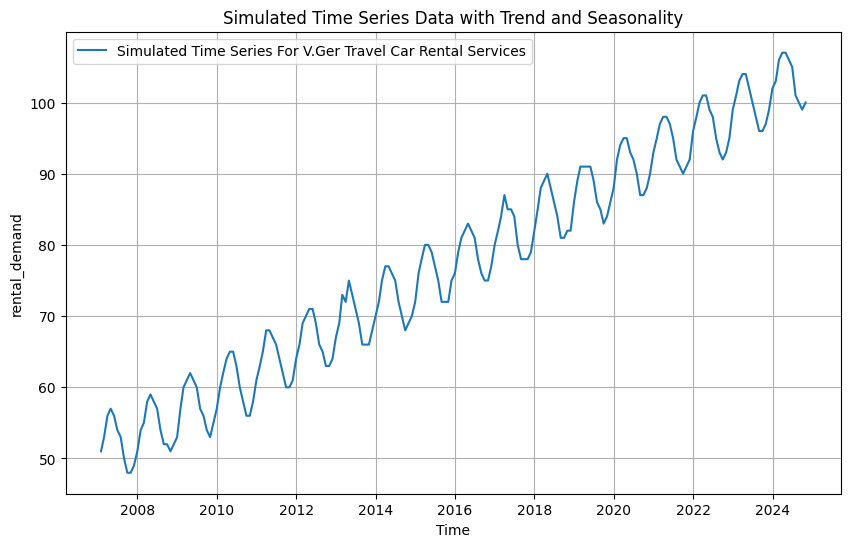

Time series data saved to 'generated_time_series.csv'.


In [ ]:
n_periods=214
frequency='months'
trend_slope=0.25
seasonal_period='monthly'
seasonal_amplitude= 5
noise_level=0.5
base_demand = 50
start_date = '2007-01-01'
x_col, y_col = 'Time', 'rental_demand'
file_name = 'car_rental.csv'
col_data = 'car_type'
col_map = 'base_cost'
col_apply = 'brand'


time_series_generator = TimeSeriesGenerator(n_periods, frequency, trend_slope, seasonal_period, seasonal_amplitude, noise_level, base_demand)
car_rental = carRentalTimeSeries()
data_frame_generator = dataFrameGenerator()
car_rental_data = carRentalData(time_series_generator, data_frame_generator, n_periods, start_date, col_data, col_map, col_apply)

car_rental_df = car_rental.generate_car_rental_time_series(car_rental_data, x_col, y_col)
time_series_generator.plot_time_series(car_rental_df, x_col, y_col)
time_series_generator.save_to_csv(car_rental_df, file_name)



In [ ]:
car_rental_df.tail()

Time  rental_demand car_type  base_cost      brand
209 2024-06-30          105.0  Compact         30      Honda
210 2024-07-31          101.0      SUV         70       Ford
211 2024-08-31          100.0      SUV         70  Chevrolet
212 2024-09-30           99.0  Compact         30      Honda
213 2024-10-31          100.0      SUV         70  Chevrolet

In [ ]:
display(car_rental_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           214 non-null    datetime64[ns]
 1   rental_demand  214 non-null    float64       
 2   car_type       214 non-null    object        
 3   base_cost      214 non-null    int64         
 4   brand          214 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 8.5+ KB


None

In [ ]:
from tabulate import tabulate

summary = car_rental_df.describe().T
display(summary)
print(tabulate(summary, headers='keys', floatfmt=".2f", tablefmt="grid"))

count                           mean                  min  \
Time             214  2015-12-15 10:45:58.878504704  2007-01-31 00:00:00   
rental_demand  214.0                      77.252336                 48.0   
base_cost      214.0                      64.392523                 30.0   

                               25%                  50%                  75%  \
Time           2011-07-07 18:00:00  2015-12-15 12:00:00  2020-05-23 06:00:00   
rental_demand                 64.0                 77.0                 91.0   
base_cost                     50.0                 70.0                100.0   

                               max        std  
Time           2024-10-31 00:00:00        NaN  
rental_demand                107.0  15.887275  
base_cost                    100.0  26.025541

+---------------+---------+-------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------+
|               |   count | mean                          | min                 | 25%                 | 50%                 | 75%                 | max                 |    std |
+===============+=========+===============================+=====================+=====================+=====================+=====================+=====================+========+
| Time          |  214.00 | 2015-12-15 10:45:58.878504704 | 2007-01-31 00:00:00 | 2011-07-07 18:00:00 | 2015-12-15 12:00:00 | 2020-05-23 06:00:00 | 2024-10-31 00:00:00 | nan    |
+---------------+---------+-------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------+
| rental_demand |  214.00 | 77.25233644859813             | 48.0                | 64.0                | 7

In [ ]:

def profile_report_generator(df, title):
  profile_report = ProfileReport(df, title = title)
  profile_report.config.html.full_width = True
  profile_report.to_notebook_iframe()
  return profile_report

In [ ]:
profile_report_generator(car_rental_df.describe(), '')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

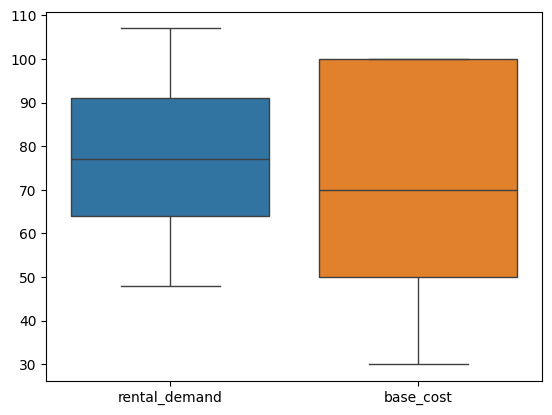

In [ ]:
#boxplot of distribution
sns.boxplot(data=car_rental_df)
plt.show()

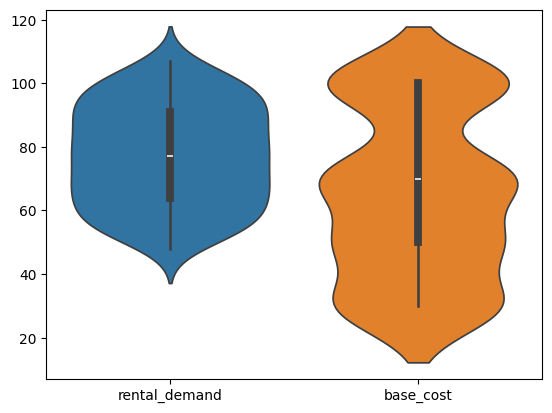

In [ ]:
sns.violinplot(data=car_rental_df)
plt.show()

In [ ]:
profile_report_generator(car_rental_df, "Car Rental Profile Data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

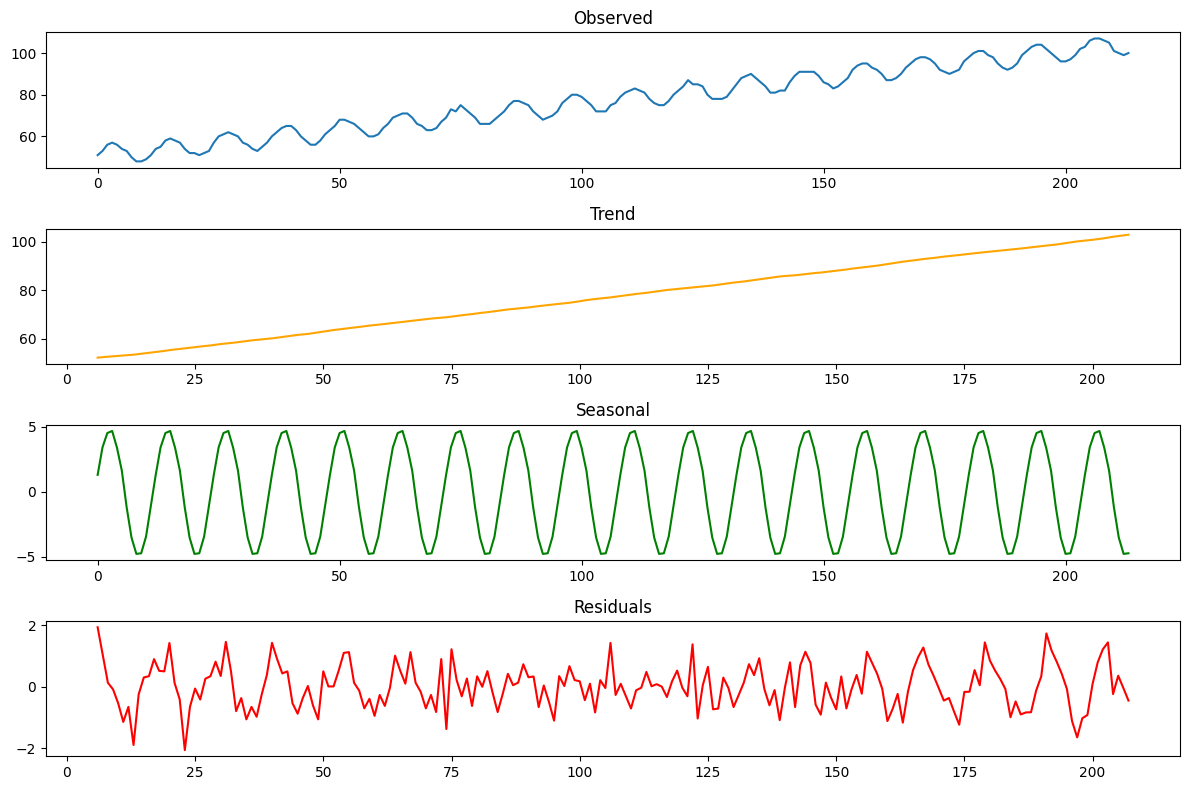

In [ ]:
decomposition = time_series_generator.decompose_time_series(car_rental_df, x_col, y_col)

time_series_generator.plot_decomposition(decomposition)

In [ ]:
# file_name = 'generated_car_rental.csv'
# file_name = 'generated_time_series.csv'
# car_rental_df = pd.read_csv(file_name)
# car_rental_df[x_col] = pd.to_datetime(car_rental_df[x_col])
# car_rental_df.set_index(x_col, inplace=True)
# car_rental_df.info()

In [ ]:
#plot pacf and acf to determine potential order of p

def plot_fn(df: pd.DataFrame, y_col: str, plot_fn, title: str, x_label: str, y_label: str, lags: int=0):
  plt.figure(figsize=(12, 6))
  if lags:
    plot_fn(df[y_col], lags=lags)
  else:
    plot_fn(df[y_col])

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.grid(True)
  plt.tight_layout()
  plt.show()




In [ ]:
#plot data

y_col = 'rental_demand'
plot = plt.plot
title = "Rental Demand"
x_label = "Date"
y_label = "Rental Demand"
acf = plot_acf

# plot_fn(car_rental_df, y_col, plot, title, x_label, y_label)


<Figure size 1200x600 with 0 Axes>

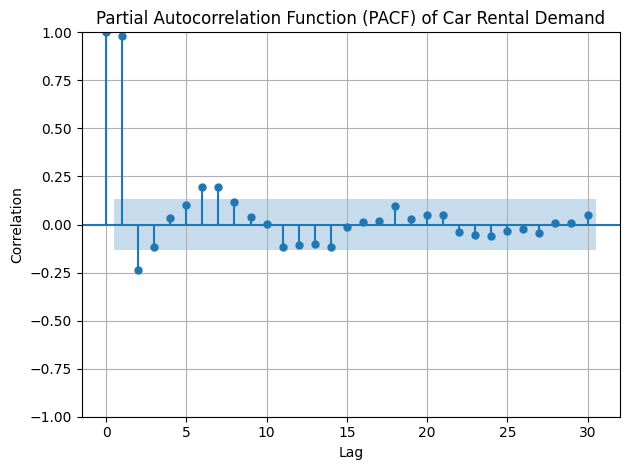

In [ ]:
title = "Partial Autocorrelation Function (PACF) of Car Rental Demand"
x_label = "Lag"
y_label = "Correlation"

plot_fn(car_rental_df, y_col, plot_pacf, title, x_label, y_label, lags=30)
# plot_fn(car_rental_df, y_col, plot_acf, title, x_label, y_label, lags=30)


I observe significant spikes going beyond the confidence bands at lags 1, 2, and 3. This suggests a strong correlation between rental demand at the current time and its values 1, 2 and 3 lags ago. Though the correlation at lag 3, is not as significant at lags 1 and 2.

Inference:
Based on the plot, an Auto Regressive model with and order of p = 3, is likely to be a suitable choice to capture short term dependencies in the data.

Recommendations
I am going to test perfromance of the model at order 2 AR(2), and select the best model between AR(2) and AR(3)

In [ ]:
#test for stationarity
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def is_stationary(df:pd.DataFrame, y_col: str) -> bool:
  adfuller_result = adfuller(df[y_col])
  print(f'ADF Statistic: {adfuller_result[0]}')
  print(f'p-value: {adfuller_result[1]}')
  print(f'Critical Values: {adfuller_result[4]}')
  return "stationary" if adfuller_result[1] <= 0.05 else "non-stationary"

is_stationary(car_rental_df, y_col)

ADF Statistic: 0.8231351237103064
p-value: 0.9920005812608473
Critical Values: {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}


'non-stationary'

In [ ]:
#prepare the data
car_rental_df['Time'] = pd.to_datetime(car_rental_df['Time'])
car_rental_df.set_index('Time', inplace=True)

In [ ]:
# size = int(0.85*len(car_rental_df))
# train_df = car_rental_df[:size][y_col]
# test_df = car_rental_df[size:][y_col]
# train_df.head()

# Split the data into training and test sets
forecast_horizon = 12  # Reserve the last 1 to 3 years for testing
train_df = car_rental_df[:-forecast_horizon]
test_df = car_rental_df[-forecast_horizon:]

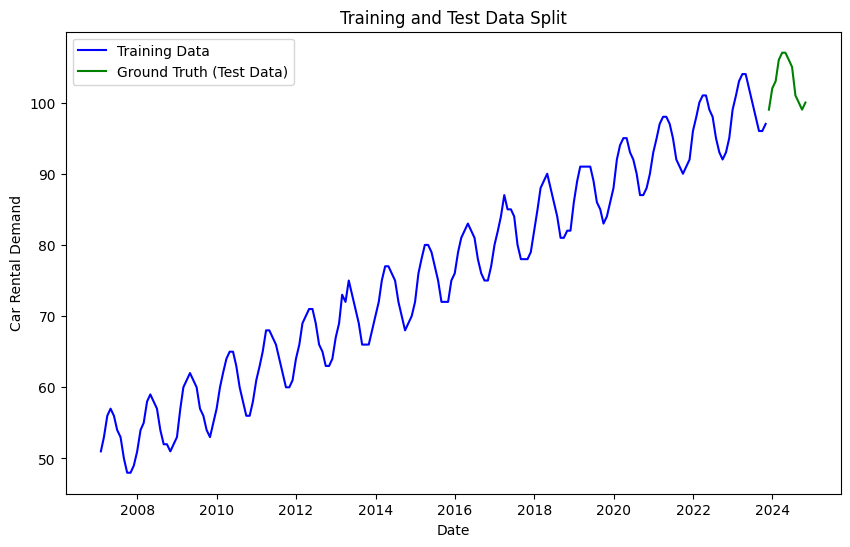

In [ ]:
# Plot the training data and ground truth (test data)
plt.figure(figsize=(10, 6))
plt.plot(train_df[y_col], label='Training Data', color='blue')
plt.plot(test_df[y_col], label='Ground Truth (Test Data)', color='green')
plt.title('Training and Test Data Split')
plt.xlabel('Date')
plt.ylabel('Car Rental Demand')
plt.legend()
plt.show()

In [ ]:
# Fit the SARIMA model with automatic parameter selection

car_rental_sarima_model = pm.auto_arima(
    train_df['rental_demand'],
    start_p=1, max_p=3,            # Non-seasonal AR terms
    start_q=1, max_q=3,            # Non-seasonal MA terms
    start_P=0, max_P=3,            # Seasonal AR terms
    start_Q=0, max_Q=3,            # Seasonal MA terms
    d=1,                           # Differencing order
    D=1,                           # Seasonal differencing order
    m=12,                          # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,                 # Enable seasonality
    stepwise=True,                 # Enable stepwise search
    trace=True,                    # Output model selection details
    information_criterion='aic'    # Criterion for model selection
)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=6.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=587.406, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=475.863, Time=1.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=8.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=531.377, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=451.642, Time=2.38 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[12]             : AIC=450.209, Time=4.35 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,1)[12]             : AIC=448.952, Time=13.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=446.952, Time=3.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=447.152, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.34 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=13.00 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[12]             : AIC=495.423, Time=0.98 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[12]             : AIC=431.868, Time=1.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[12]             : AIC=431.490, Time=1.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[12]             : AIC=433.085, Time=0.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=449.468, Time=0.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=7.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=504.149, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,2)[12]             : AIC=430.323, Time=1.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,3)[12]             : AIC=430.201, Time=2.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,3)[12]             : AIC=inf, Time=7.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,3)[12]             : AIC=445.733, Time=4.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,1,3)[12]             : AIC=427.777, Time=2.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,1,2)[12]             : AIC=428.220, Time=1.49 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,3)[12]             : AIC=inf, Time=11.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,2)[12]             : AIC=inf, Time=5.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,3)[12]             : AIC=inf, Time=14.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,3)[12]             : AIC=inf, Time=11.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,1,3)[12] intercept   : AIC=429.767, Time=2.95 sec

Best model:  ARIMA(3,1,0)(0,1,3)[12]          
Total fit time: 138.848 seconds


In [ ]:
print(car_rental_sarima_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  202
Model:             SARIMAX(3, 1, 0)x(0, 1, [1, 2, 3], 12)   Log Likelihood                -206.889
Date:                                    Mon, 13 Jan 2025   AIC                            427.777
Time:                                            18:58:08   BIC                            450.469
Sample:                                        01-31-2007   HQIC                           436.970
                                             - 10-31-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7466      0.074    -10.078      0

Key Information:

Model: SARIMAX(1, 1, 2)
This indicates that the model is a Seasonal Autoregressive Integrated Moving Average model.
(2, 1, 2) represents the non-seasonal ARIMA parameters:
AR order (p) = 2
Differencing order (d) = 1
MA order (q) = 2
Log Likelihood: -232.258 - A measure of the model's fit to the data. Higher values generally indicate a better fit.
AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), HQIC (Hannan-Quinn Information Criterion): Model selection criteria. Lower values generally indicate a better model.
Covariance Type: 'opg' - This likely refers to the covariance type used in the estimation process.
Coefficient Table:

intercept: A constant term in the model.
ar.L1, ar.L2: Autoregressive coefficients at lags 1 and 2.
ma.L1, ma.L2: Moving average coefficients at lags 1 and 2.
sigma2: The estimated variance of the error term.
Diagnostic Tests:

Ljung-Box Test (Q):
Tests the null hypothesis that the residuals are serially uncorrelated.
A high p-value (0.97) suggests that there is no significant autocorrelation in the residuals, indicating a good model fit.
Jarque-Bera Test (JB):
Tests the null hypothesis that the residuals are normally distributed.
A high p-value (0.40) indicates that the residuals are not significantly different from a normal distribution.
Heteroskedasticity Test (H):
Tests for heteroscedasticity (non-constant variance) in the residuals.
A high p-value (0.69) suggests that there is no significant heteroscedasticity.
Skew and Kurtosis:
These measures describe the shape of the residual distribution.
Skew = 0.12 suggests a slight positive skew.
Kurtosis = 3.45 is close to the normal distribution's kurtosis (3), indicating a relatively normal shape.
Overall Interpretation:

Based on the provided results, the SARIMAX(2, 1, 2) model appears to be a reasonable fit for the data.

The model has a relatively low AIC, BIC, and HQIC values.
The diagnostic tests (Ljung-Box, Jarque-Bera, and Heteroskedasticity) indicate that the model residuals are likely uncorrelated, normally distributed, and have constant variance.
However, it's important to consider the context of the data and perform further analysis (e.g., cross-validation, residual plots, forecast evaluation) to ensure the model's accuracy and reliability for prediction.

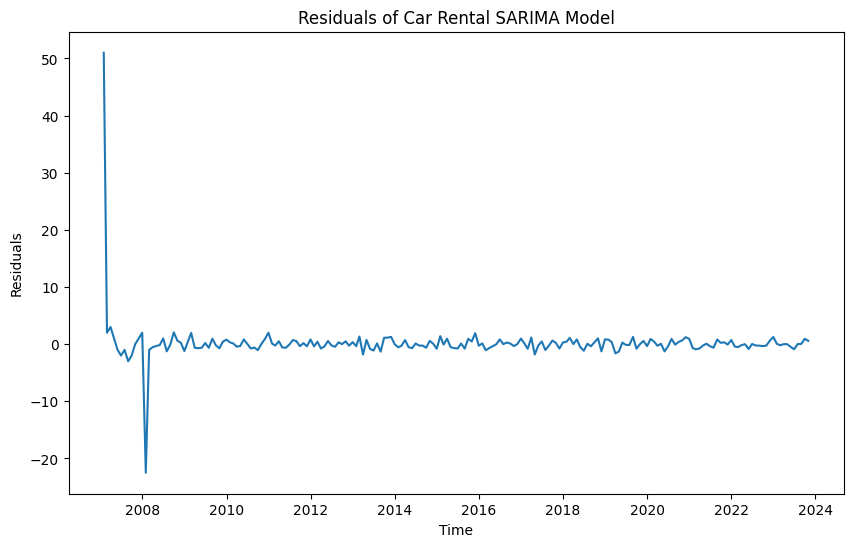

<Figure size 1000x600 with 0 Axes>

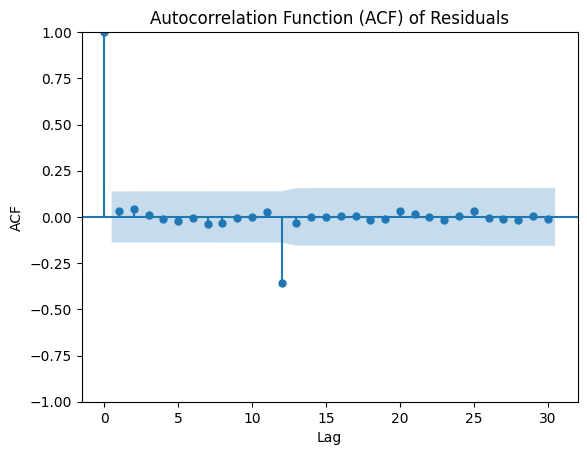

In [ ]:
residual = car_rental_sarima_model.arima_res_.resid

title = "Residuals of Car Rental SARIMA Model"
x_label = "Time"
y_label = "Residuals"

# Plot residuals to inspect for patterns
plt.figure(figsize=(10,6))
plt.plot(residual)
plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

# Plot ACF of residuals to check for remaining autocorrelation
plt.figure(figsize=(10,6))
plot_acf(residual, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# plot_fn(df, y_col, plot_pacf, title, x_label, y_label, lags=30)

In [ ]:
#implement durbin watson to test correlation in residuals
durbin_watson_result = sm.stats.stattools.durbin_watson(residual)
print(f'Durbin-Watson Statistic: {durbin_watson_result}')

Durbin-Watson Statistic: 1.1365420446110648


Majority of the data points are within the confidence intervals, sugessting lack of significant auto correlations at most lags. This indicates a good fit of the model to the data points.

This was achieved after various customizations of the sarima parameters. The values of the lowest AIC and BIC achievesd, were

In [ ]:
#forecast future data.
# car_rental_sarima_model.plot_diagnostics(figsize=(15, 12))
# plt.show()

In [ ]:
#forecast months ahead demand

m_periods = len(test_df)  # Forecast for the test set period
forecast, conf_int = car_rental_sarima_model.predict(m_periods, return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Create a range of dates for the forecasted values
forecast_dates = test_df.index
# forecast_dates = pd.date_range(start=car_rental_df.index[size-1], periods=m_periods+1, freq='M')[1:]
# forecast_dates = pd.date_range(start=df.index[size-1], periods=m_periods + 1, freq='M')[1:]

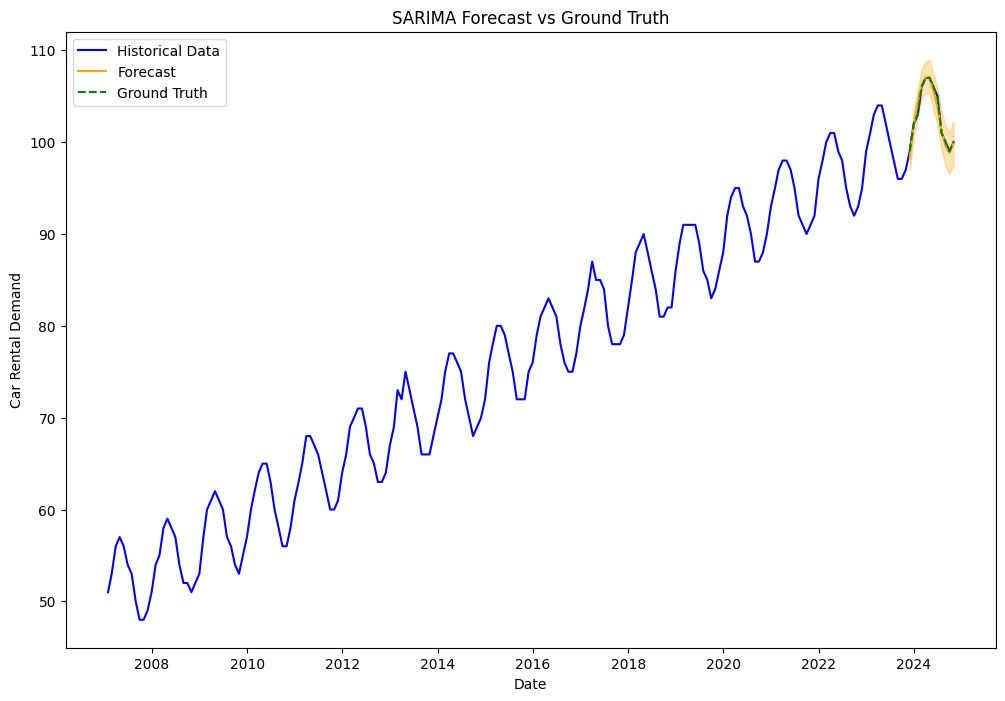

In [ ]:
# Plot historical data, forecast, and ground truth
plt.figure(figsize=(12, 8))
plt.plot(car_rental_df[y_col], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='orange')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3)
plt.plot(test_df[y_col], label='Ground Truth', color='green', linestyle='dashed')
plt.title('SARIMA Forecast vs Ground Truth')
plt.xlabel('Date')
plt.ylabel('Car Rental Demand')
plt.legend()
plt.show()

In [ ]:
# visualize data

def plot_data(df: pd.DataFrame, title: str, x_label: str, y_label: str, grid: bool, fig: Tuple[int, int], conf_interval: np.ndarray, *args, **kwargs):
  plt.figure(figsize=fig)
  for arg in args:
    if isinstance(arg, str):
      plt.plot(df[arg], label=kwargs.get(arg)[0], color=kwargs.get(arg)[1])
    else:
      plt.plot(arg, kwargs.get("forecast")[2], label=kwargs.get("forecast")[0], color=kwargs.get("forecast")[1])

  if len(conf_interval):
    plt.fill_between(forecast_dates, conf_interval[:, 0], conf_interval[:, 1], color='orange', alpha=0.3)

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.tight_layout()
  plt.grid(grid)
  plt.show()

In [ ]:
# Plot historical data and the forecast with confidence intervals
# title = 'SARIMA Forecast of Monthly Car Rental Demand'
# x_label = 'Date'
# y_label = 'Rental Demand'
# grid = True
# fig = (12, 6)
# kwargs = {
#     y_col: ('Historical Data', 'blue'),
#     "forecast" : ('Forecast', 'red', forecast)
# }
# args = [y_col, forecast_dates]

# plot_data(car_rental_df, title, 'Date', 'Rental Demand', grid, fig, conf_int, *args, **kwargs)


In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

def calculate_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)

  return mae, mse, rmse


In [ ]:
mae, mse, rmse = calculate_metrics(test_df[y_col], forecast)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 0.44103363011314417
Mean Squared Error: 0.3565062689946805
Root Mean Squared Error: 0.5970814592622019


Mean Absolute Error: 0.45843481780656486

Mean Squared Error: 0.34860824955629416

Root Mean Squared Error: 0.5904305628575592

Mean Absolute Error: 0.47256031534352044

Mean Squared Error: 0.3789022358871994

Root Mean Squared Error: 0.6155503520323902



Mean Absolute Error: 0.27935688432595285

Mean Squared Error: 0.0986245357968372

Root Mean Squared Error: 0.31404543587964656


Mean Absolute Error: 1.0321882458510399

Mean Squared Error: 1.2928526555617426

Root Mean Squared Error: 1.1370367872508536



Mean Absolute Error: 1.0166273880633672

Mean Squared Error: 1.2414958485116476

Root Mean Squared Error: 1.1142243259378461


Observations:

Historical Data: The blue line represents the historical car rental demand data. It shows an upward trend with some seasonal fluctuations.

Forecast: The red line represents the forecasted car rental demand. It extends from and beyond the historical data, indicating past and future predictions respectively.

Confidence Interval: The orange area around the forecast line represents the confidence interval for the forecast. This interval indicates the range within which the actual demand is likely to fall with a certain level of probability (95% in this case). We can see that the past predictions fall within the confidence interval, giving our predictions a high probability of correctness.

Interpretation:

Upward Trend: The historical data and the forecast both suggest an upward trend in car rental demand over time. This could be attributed to factors like population growth, economic growth, or increasing tourism or GDP. There is also the possibility that the public transport system is under performing.

Seasonality: The historical data exhibits clear seasonal fluctuations. This is likely due to factors like variations in weather, holidays, festivals, and travel seasons. The SARIMA model attempts to capture these seasonal patterns and incorporate them into the forecast.

Forecast Uncertainty: The confidence interval around the forecast diverges as we move further into the future. This is an indication that the uncertainty associated with the forecast increases with the forecast horizon.

Overall:

The plot suggests that the SARIMA model has captured the underlying trend and seasonality in the historical data and provides a reasonable forecast of future car rental demand. However, it's important to remember that the forecast is based on assumptions and historical data, and actual demand may deviate from the forecast due to unforeseen events or changing circumstances.

Further Considerations:

Model Evaluation:
Exogenous Variables: Relevant exogenous variables such as fuel prices, GDP, per capita income, annual income, debt can act as economic indicators, which can affect the demand for car rentals. Incorporating these into the model could potentially improve forecast accuracy.

Further to this, we will be introducing fuel prices as an exogenous variable.

In [ ]:
# Load and preprocess the GDP data
gdp_file = 'gdp.csv'
gdp_df = pd.read_csv(gdp_file)
gdp_df.drop(['Unnamed: 2', 'Unnamed: 3'], axis=1, inplace=True)
gdp_df.columns = ['date', 'gdp']
gdp_df['date'] = pd.to_datetime(gdp_df['date'])
gdp_df.set_index('date', inplace=True)
gdp_df = gdp_df['2007-01-01':]
# print(gdp_df.head())


<ipython-input-289-776f831ddba7>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdp_df['date'] = pd.to_datetime(gdp_df['date'])


In [ ]:
profile_report_generator(gdp_df, "GDP Profile Data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#rename date column to time
# gdp_df.rename(columns={'date': x_col}, inplace=True)

In [ ]:
#create a new column that is called year_month from gdp_df and car_rental_df
gdp_df['year_month'] = gdp_df.index.strftime('%Y-%m')
# car_rental_df['year_month'] = car_rental_df.index.strftime('%Y-%m')
car_rental_year_df = car_rental_df.assign(year_month=car_rental_df.index.strftime('%Y-%m'))

gdp_df['year_month'] = pd.to_datetime(gdp_df['year_month'])
car_rental_year_df['year_month'] = pd.to_datetime(car_rental_year_df['year_month'])
gdp_df.set_index('year_month', inplace=True)
car_rental_year_df.set_index('year_month', inplace=True)

display(gdp_df.tail())
print(car_rental_year_df.tail())

gdp
year_month           
2024-06-01  29091.086
2024-07-01  29320.176
2024-08-01  29408.442
2024-09-01  29343.191
2024-10-01  29523.676

            rental_demand car_type  base_cost      brand
year_month                                              
2024-06-01          105.0  Compact         30      Honda
2024-07-01          101.0      SUV         70       Ford
2024-08-01          100.0      SUV         70  Chevrolet
2024-09-01           99.0  Compact         30      Honda
2024-10-01          100.0      SUV         70  Chevrolet


In [ ]:
# Ensure alignment by joining on the index (Month)
car_rental_gdp_df = car_rental_year_df.join(gdp_df, how='inner')
# car_rental_gdp_df.rename(columns={'value': 'GDP'}, inplace=True)
profile_report_generator(car_rental_gdp_df.describe(), '')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

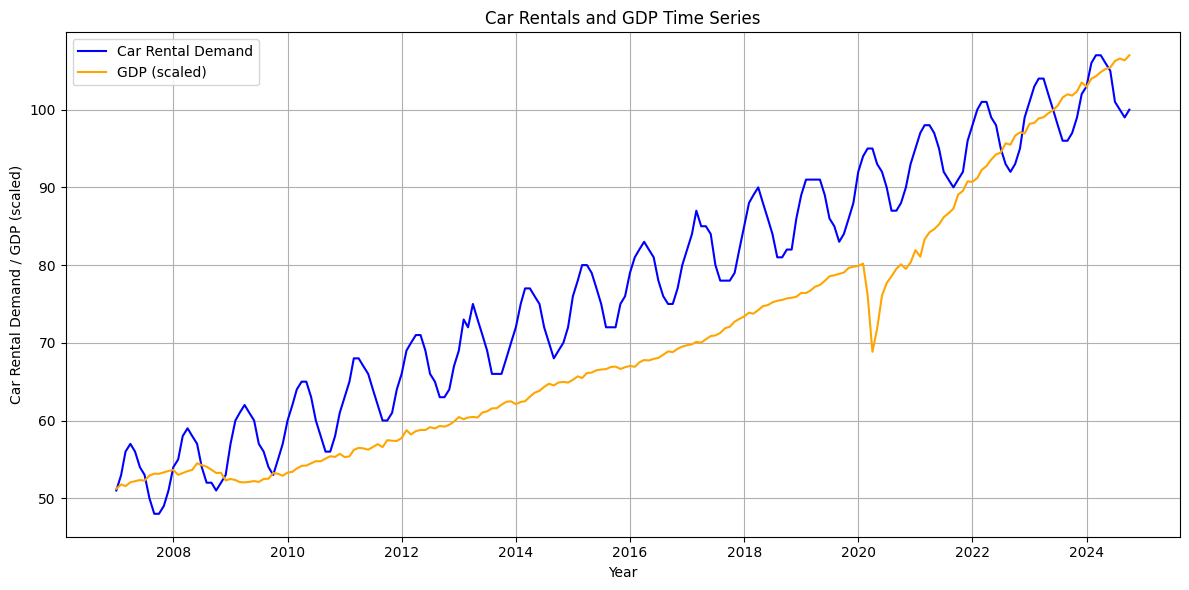

In [ ]:
# Plotting Car Rental Demand and GDP
plt.figure(figsize=(12, 6))
plt.plot(car_rental_gdp_df['rental_demand'], label='Car Rental Demand', color='blue')
scaled_gdp = car_rental_gdp_df['gdp'] / car_rental_gdp_df['gdp'].max() * car_rental_gdp_df[y_col].max()
plt.plot(scaled_gdp, label='GDP (scaled)', color='orange')
plt.title('Car Rentals and GDP Time Series')
plt.xlabel('Year')
plt.ylabel('Car Rental Demand / GDP (scaled)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Split data into training and testing sets
train_ratio = 0.8  # Use 80% of data for training
train_size = int(len(car_rental_gdp_df) * train_ratio)

train = car_rental_gdp_df.iloc[:train_size]
test = car_rental_gdp_df.iloc[train_size:]

# Extract the series and external variable
y_train = train[y_col]
y_test = test[y_col]
exog_train = train['gdp']
exog_test = test['gdp']

In [ ]:
# Auto_arima to find the best parameters
print("Running auto_arima to find the best parameters...")
auto_model = pm.auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=True,
    m=12,  # Monthly data
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

# Best parameters from auto_arima
print(f"\nOptimal Order: {auto_model.order}")
print(f"Optimal Seasonal Order: {auto_model.seasonal_order}")
print(f"Best AIC: {auto_model.aic():.2f}")

Running auto_arima to find the best parameters...
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=717.036, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=625.240, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=718.350, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=662.427, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=419.063, Time=1.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.86 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=9.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.55 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=600.512, Time=0.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=2.70 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=8.95 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=481.049, Time=0.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=416.205, Time=1.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=613.333, Time=0.27 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=9.02 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=632.263, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=596.516, Time=0.80 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=429.693, Time=2.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=6.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=419.373, Time=1.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=418.802, Time=2.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=415.192, Time=1.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=601.101, Time=0.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=4.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=4.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=421.135, Time=2.73 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=630.160, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=591.277, Time=0.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=427.568, Time=1.82 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=7.70 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[12] intercept   : AIC=428.429, Time=1.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[12] intercept   : AIC=inf, Time=2.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=424.456, Time=1.00 sec

Best model:  ARIMA(0,1,2)(1,0,1)[12] intercept
Total fit time: 93.914 seconds

Optimal Order: (0, 1, 2)
Optimal Seasonal Order: (1, 0, 1, 12)
Best AIC: 415.19


In [ ]:
auto_model.order
auto_model.seasonal_order

(1, 0, 1, 12)

In [ ]:
# Fit a SARIMAX model with auto_arima parameters
sarimax_model = SARIMAX(
    y_train,
    exog=exog_train,
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order


)
sarimax_fit = sarimax_model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        rental_demand   No. Observations:                  171
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -212.994
Date:                              Mon, 13 Jan 2025   AIC                            437.989
Time:                                      19:10:38   BIC                            456.803
Sample:                                  01-01-2007   HQIC                           445.623
                                       - 03-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gdp         9.552e-06      0.000      0.041      0.967      -0.000       0.000
ma.L1         -0.68

In [ ]:
# Fit a SARIMAX model without auto_arima parameters
sarimax_model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(0, 1, 2),
    seasonal_order=(1, 1, 1, 12)

)
sarimax_fit = sarimax_model.fit(disp=False)

# Model summary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        rental_demand   No. Observations:                  171
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -172.409
Date:                              Mon, 13 Jan 2025   AIC                            356.818
Time:                                      19:14:10   BIC                            375.194
Sample:                                  01-01-2007   HQIC                           364.281
                                       - 03-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gdp            0.0001      0.000      0.623      0.534      -0.000       0.000
ma.L1         -0.84

In [ ]:
# Forecasting on the test set
forecast = sarimax_fit.get_forecast(steps=len(test), exog=exog_test)
forecast_df = forecast.conf_int()
# print("forecast_df", forecast_df)

# forecast_df['Forecast'] = forecast.predicted_mean

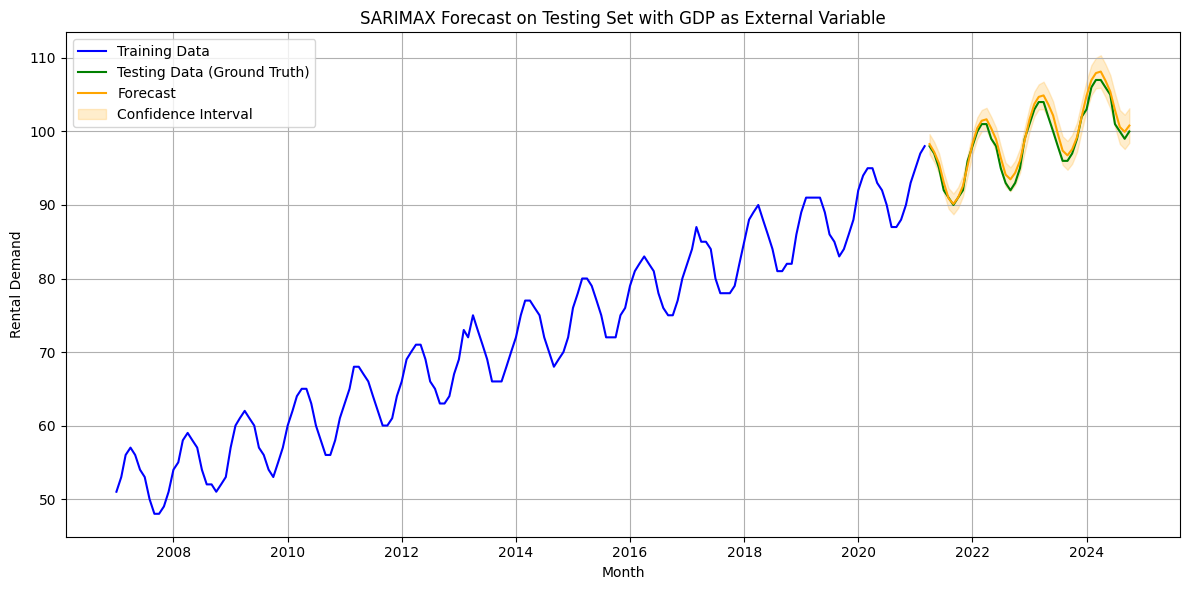

In [ ]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Training Data', color='blue')
plt.plot(y_test, label='Testing Data (Ground Truth)', color='green')
plt.plot(forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(
    forecast_df.index,
    forecast_df['lower rental_demand'],
    forecast_df['upper rental_demand'],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title('SARIMAX Forecast on Testing Set with GDP as External Variable')
plt.xlabel('Month')
plt.ylabel('Rental Demand')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

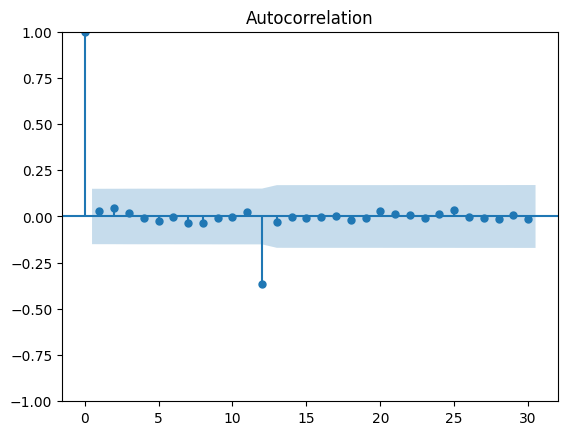

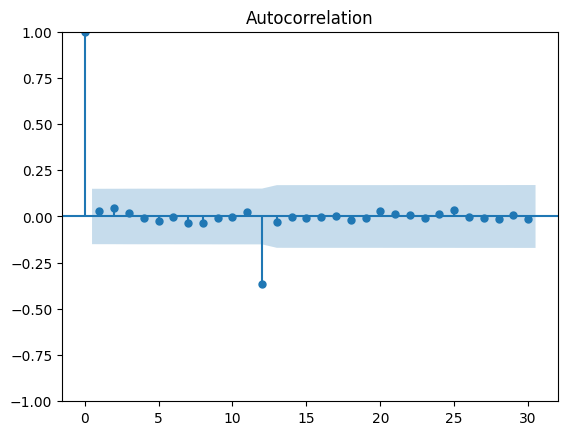

In [ ]:
plot_acf(sarimax_fit.resid, lags=30)

In [ ]:
mae, mse, rmse = calculate_metrics(y_test, forecast.predicted_mean)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 0.8490379324714676
Mean Squared Error: 1.007134989635193
Root Mean Squared Error: 1.0035611539090148


In [ ]:
# Generate fuel price data with some trend and seasonality
np.random.seed(42)
n_periods = len(car_rental_gdp_df)  # Length of the time series

# Define parameters
trend_slope = 0.10  # Slope of the trend
seasonal_amplitude = 1  # Amplitude of the seasonal component
noise_std = 1  # Standard deviation of the noise

# Generate time indices
time_index = np.arange(n_periods)  # Create an array of time indices

# Generate trend component
trend = trend_slope * time_index

# Generate seasonal component
seasonal = seasonal_amplitude * np.sin(2 * np.pi * time_index / 12)

# Generate noise
noise = np.random.normal(0, noise_std, n_periods)

# Combine components to generate fuel prices
fuel_price = 30 + trend + seasonal + noise

# Apply a lower bound to fuel prices (optional)
fuel_price = np.clip(fuel_price, 0, None)  # Set lower bound to 0



In [ ]:
# Create a new column in the DataFrame
data_frame_generator.create_column_data(car_rental_gdp_df, 'fuel_price', fuel_price)
# data_frame_generator.create_column_data(car_rental_df, 'fuel_price', fuel_price)
car_rental_gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214 entries, 2007-01-01 to 2024-10-01
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rental_demand  214 non-null    float64
 1   car_type       214 non-null    object 
 2   base_cost      214 non-null    int64  
 3   brand          214 non-null    object 
 4   gdp            214 non-null    float64
 5   fuel_price     214 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 11.7+ KB


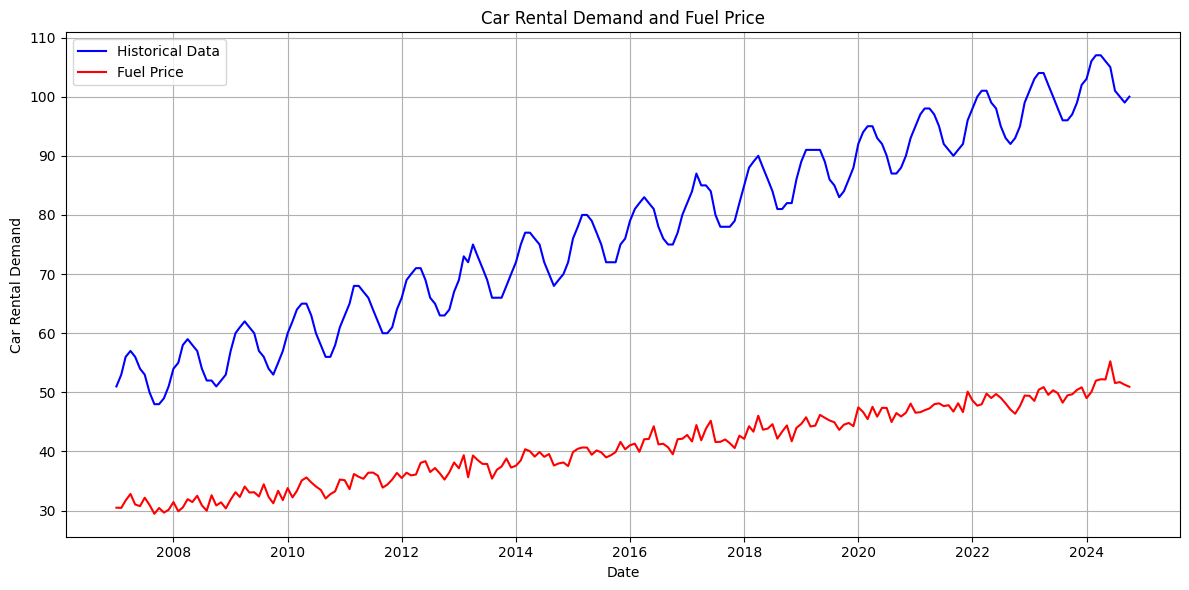

In [ ]:
kwargs = {
     y_col: ('Historical Data', 'blue'),
    'fuel_price': ('Fuel Price', 'red')
}
title = "Car Rental Demand and Fuel Price"
x_label = "Date"
y_label = "Car Rental Demand"
grid = True
fig = (12, 6)

plot_data(car_rental_gdp_df, title, x_label, y_label, grid, fig, [], *kwargs.keys(), **kwargs)


In [ ]:
# train_ratio = 0.8  # Use 80% of data for training
# train_size = int(len(car_rental_df) * train_ratio)

train = car_rental_gdp_df.iloc[:train_size]
test = car_rental_gdp_df.iloc[train_size:]

# Extract the series and external variable
y_train_fuel = train[y_col]
y_test_fuel = test[y_col]

exog_train_fuel = train['fuel_price']
exog_test_fuel = test['fuel_price']
display(y_train_fuel.shape, exog_train.shape, exog_train_fuel.shape )

(171,)

(171,)

(171,)

In [ ]:
exog_train = np.column_stack((exog_train, exog_train_fuel))  # Combine exog1 and exog2 into a 2D array
exog_test = np.column_stack((exog_test, exog_test_fuel))  # Combine exog1 and exog2 into a 2D array


In [ ]:
# Fit SARIMAX model with fuel price as an exogenous variable
sarimax_model = SARIMAX(
    endog=y_train_fuel,
    order=(1, 1, 0),               # ARIMA(p, d, q) parameters
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) parameters
    enforce_stationarity=True,    # Set to True if you want to enforce stationarity
    exog=exog_train # Exogenous variable: Fuel Price
)
sarimax_results = sarimax_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


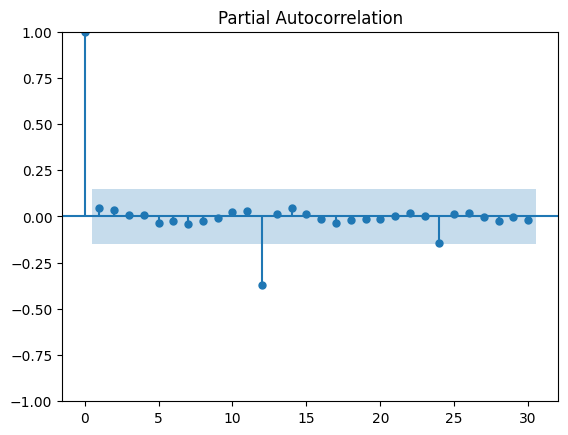

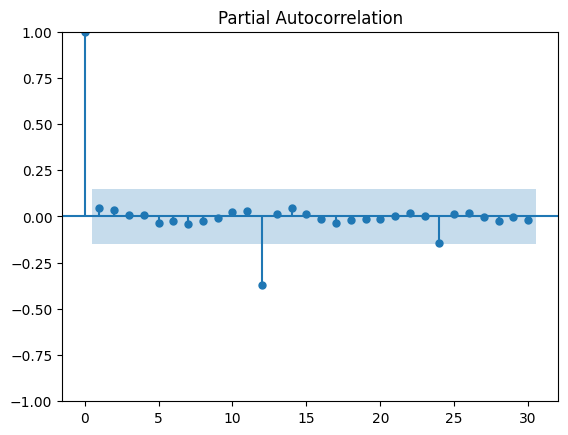

In [ ]:
sarimax_results.summary()
# sarimax_results.resid
plot_pacf(sarimax_results.resid, lags=30)

In [ ]:
# Forecast future values
# m_periods = 24  # Forecast for 1 year ahead
# np.random.seed(42)
# future_fuel_price = 50 + 2 * np.sin(np.linspace(3 * np.pi, 4 * np.pi, m_periods)) + np.random.normal(0, 1, m_periods)
# future_fuel_price = np.clip(future_fuel_price, 0, 100)
y_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 43 entries, 2021-04-01 to 2024-10-01
Series name: rental_demand
Non-Null Count  Dtype  
--------------  -----  
43 non-null     float64
dtypes: float64(1)
memory usage: 688.0 bytes


In [ ]:
# Make predictions
m_periods = len(y_test)  # Forecast for the test set period
# future_fuel_price = test_df
sarimax_model_forecast_exg = sarimax_results.get_forecast(steps=m_periods, exog=exog_test)
# sarimax_model_forecast_exg.predicted_mean
forecast_index = y_test.index
forecast_conf_int = sarimax_model_forecast_exg.conf_int()
# forecast_conf_int

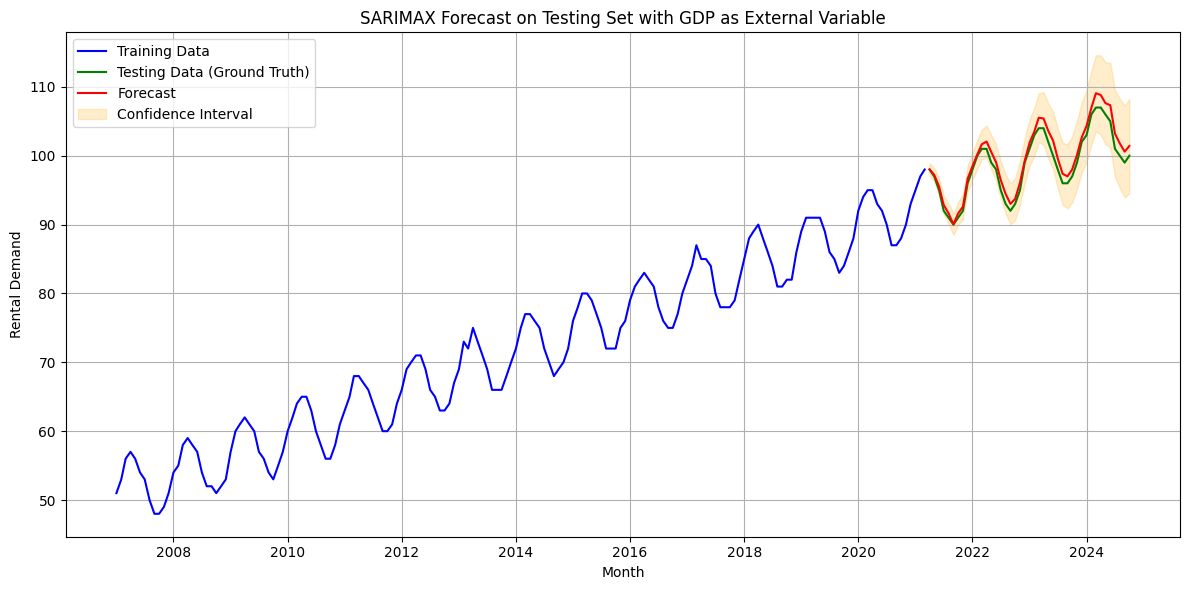

In [ ]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Training Data', color='blue')
plt.plot(y_test, label='Testing Data (Ground Truth)', color='green')
plt.plot(sarimax_model_forecast_exg.predicted_mean, label='Forecast', color='red')
plt.fill_between(
    forecast_index,
    forecast_conf_int['lower rental_demand'],
    forecast_conf_int['upper rental_demand'],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title('SARIMAX Forecast on Testing Set with GDP as External Variable')
plt.xlabel('Month')
plt.ylabel('Rental Demand')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
mae, mse, rmse = calculate_metrics(y_test, sarimax_model_forecast_exg.predicted_mean)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 1.0993164228854952
Mean Squared Error: 1.5593785000262361
Root Mean Squared Error: 1.2487507757860397


1. n_periods (Number of Time Steps)

    Description: Specifies how many data points you want to generate.
    Usage: Affects the length of the time series.
    Example Values:
        n_periods=100 for a short time series.
        n_periods=500 for a longer time series.
    Default: 100.

2. frequency (Time Frequency)

    Description: Defines the time intervals of the series.
    Options:
        'days': Daily time intervals.
        'weeks': Weekly time intervals.
        'months': Monthly time intervals.
    Usage: Determines the time range of the time series.
    Example Values:
        frequency='days' for daily observations.
        frequency='weeks' for weekly data.
        frequency='months' for monthly data.
    Default: 'days'.

3. trend_slope (Linear Trend Slope)

    Description: Controls how quickly the trend increases over time.
    Usage: Affects the magnitude of the overall increase in the series.
    Example Values:
        trend_slope=0.1: A slow-growing trend.
        trend_slope=0.5: A faster-growing trend.
        trend_slope=0: No trend (flat).
    Default: 0.3.

4. seasonal_period (Seasonal Pattern)

    Description: Specifies the type of seasonality to include in the series.
    Options:
        'monthly': Seasonal variations occur every 12 periods (e.g., months in a year).
        'weekly': Seasonal variations occur every 52 periods (e.g., weeks in a year).
        'annual': Seasonal variations occur every 365 periods (e.g., days in a year).
    Usage: Adjust this to reflect real-world seasonality based on the data's frequency.
    Example Values:
        seasonal_period='monthly' for sales data.
        seasonal_period='weekly' for weekly activity patterns.
        seasonal_period='annual' for long-term trends.
    Default: 'monthly'.

5. seasonal_amplitude (Strength of Seasonality)

    Description: Controls the magnitude of the seasonal fluctuations.
    Usage: Sets the "height" of seasonal oscillations relative to the trend.
    Example Values:
        seasonal_amplitude=2: Subtle seasonal variation.
        seasonal_amplitude=10: Strong seasonal variation.
    Default: 5.

6. noise_level (Random Variation)

    Description: Adds random noise to simulate natural variability in the data.
    Usage: Higher values create noisier data, while lower values make it smoother.
    Example Values:
        noise_level=0: No noise.
        noise_level=0.5: Moderate noise.
        noise_level=2: High noise.
    Default: 0.5.

Tips for Setting Parameters:

    Match Seasonality to Frequency: Ensure that the seasonal_period makes sense for the chosen frequency.
        Example: For frequency='months', use seasonal_period='monthly' for realistic results.
    Control Noise for Clarity: Use noise_level=0 for clean series or increase it slightly (e.g., 0.2) to simulate real-world randomness.
    Trend Dominance: Ensure the trend_slope is much larger than seasonal_amplitude if you want the trend to dominate over seasonality.